Here we illustrate how to sample n-body particles with Galaxia.

A simple application is to provide a flat starformation history with reasonable age-metallicity relation in order to sample a colour magnitude diagram and look at the occupation of CMD space by the different stellar populations and look at their astrophysical parameters. Like that we can for example sample the age distribution of RGB stars. The technique was first described here: http://adsabs.harvard.edu/abs/2016AN....337..880J

In [1]:
%pylab inline
import ebf
import shutil
import subprocess
from astropy.io import fits
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Need to specify where the GalaxiaData folder is and how to name the new simulation

nbody_folder = '/home/rybizki/Programme/GalaxiaData/'
folder = 'flat_sfr/'
filename = 'flat_sfr_selection_down_to_5'
folder_cat = '../output/mock_cat'

In [3]:
def create_flat_sfr(nbody_folder,folder,filename):
    
    # 2 input files for Galaxia need to be created
    folder_create = nbody_folder + 'nbody1/' + folder
    if os.path.exists(folder_create):
        shutil.rmtree(folder_create)
        os.mkdir(folder_create)
        print(folder_create, "existed and was recreated")
    else:
        os.mkdir(folder_create)

    # Age metallicity distribution is specified in this input file, using Model A from Just&Jahreiß 2010
    s = '../input/zevolv02.dat'
    data1 = np.genfromtxt(s,skip_header=2, dtype=None, names = True)

    age = data1['t']
    age = age*13.5
    zfe = data1['zfe']
    zox = data1['zox']
    #fehdex = np.log10(zfe)
    # Here we can specify the AMR according to our needs
    age = np.linspace(0,13.5,num = 1001)[1:]
    fehdex = np.linspace(-1.8,-0.7,num = len(age))
    #ohdex = np.log10(zox)
    ohdex = np.ones(len(age))
    enhancement = ohdex - fehdex
    age = age[::-1]
    mass = np.divide(np.ones(len(age)),len(age))
    #################################

    # Here the ebf nbody input file is created
    pos = np.zeros((len(age),3))
    vel = np.zeros((len(age),3))
    for i in range(0,len(pos)):
        fehdex[i] = fehdex[i]
        pos[i] = np.array([ -8.00000000e+00,   0.00000000e+00,   1.50000000e-02])
        vel[i] = np.array([ 1.11000000e+01,   2.39080000e+02,   7.25000000e+00])
    ebf.write(nbody_folder + 'nbody1/' + folder + filename + '.ebf', '/mass', mass,'w')	
    ebf.write(nbody_folder + 'nbody1/' + folder + filename + '.ebf', '/feh', fehdex,'a')
    ebf.write(nbody_folder + 'nbody1/' + folder + filename + '.ebf', '/id', 1,'a')
    ebf.write(nbody_folder + 'nbody1/' + folder + filename + '.ebf', '/alpha', enhancement,'a')
    ebf.write(nbody_folder + 'nbody1/' + folder + filename + '.ebf', '/age', age,'a')
    ebf.write(nbody_folder + 'nbody1/' + folder + filename + '.ebf', '/pos3', pos,'a')
    ebf.write(nbody_folder + 'nbody1/' + folder + filename + '.ebf', '/vel3', vel,'a')

    ebf.write(nbody_folder + 'nbody1/' + folder + filename + '_d3n64_den.ebf', '/h_cubic', np.zeros(len(pos)), 'w')
    ebf.write(nbody_folder + 'nbody1/' + folder + filename + '_d6n64_den.ebf', '/h_cubic', np.zeros((len(pos),2)), 'w')

    # Here the file which tells Galaxia where to find the input file is created
    filedata = 'nbody1/%s\n         1       1\n%s.ebf\n' %(folder, filename)
    file = open(nbody_folder + "nbody1/filenames/" + filename + ".txt", "w")
    file.write(filedata)
    file.close()
    return(fehdex,age)

/home/rybizki/Programme/GalaxiaData/nbody1/flat_sfr/ existed and was recreated


Text(0.5,1,'AMR')

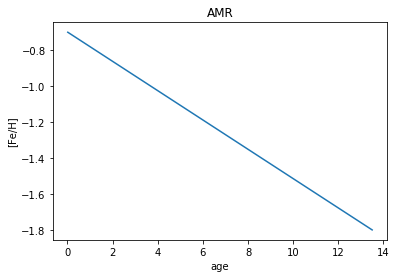

In [4]:
fehdex,age = create_flat_sfr(nbody_folder,folder,filename)
# Changing the AMR to something like fig.4 of https://ui.adsabs.harvard.edu/#abs/2014ApJ...786...44S/abstract
# Just checking if it looks OK. Change the AMR if needed within the function create_flat_sfr
plt.plot(age,fehdex)
plt.xlabel("age")
plt.ylabel("[Fe/H]")
plt.title("AMR")

Preparing a CMD of constant SFR to see what the age distribution of a specific population is

In [5]:
# Here we create the folder where Galaxia will write the mock catalogue

folder_create = folder_cat + '/'
if os.path.exists(folder_create):
    shutil.rmtree(folder_create)
    os.mkdir(folder_create)
    print(folder_create, "existed and was recreated")
else:
    os.mkdir(folder_create)

# Specifying the mag limits of that simulation
magmin = -100
magmax = 5
colmin = -100
colmax = 100
# Oversampling and seed, 
# Try to fix that value to something reasonable such that the age of the stellar population is sampled well
iterations = 1e6
seed = 1

# Creating the parameterfile
filedata = 'outputFile                          %s\nmodelFile       Model/population_parameters_BGM_update.ebf\ncodeDataDir              /home/rybizki/Programme/GalaxiaData\noutputDir                           %s\nphotoSys                            parsec1/GAIADR3\nmagcolorNames                       gaia_g,gaia_bpft-gaia_rp\nappMagLimits[0]                     -100\nappMagLimits[1]                     1000\nabsMagLimits[0]                     %f\nabsMagLimits[1]                     %f\ncolorLimits[0]                      %f\ncolorLimits[1]                      %f\ngeometryOption                      0\nlongitude                           0\nlatitude                            90\nsurveyArea                          1000\nfSample                             %d\npopID                               -1\nwarpFlareOn                         1\nseed                                %d\nr_max                               1000\nstarType                            0\nphotoError                          0\n' %(filename, folder_cat,magmin,magmax,colmin,colmax,iterations,seed)
myparameterfile = folder_cat + '/myparameterfile'
file = open(myparameterfile, "w")
file.write(filedata)
file.close()

# Starting Galaxia
p = subprocess.Popen(['galaxia', '-r', '--nfile=%s' %(filename), '--hdim=3', myparameterfile], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
out, err = p.communicate()
print(out)
print(err)

../output/mock_cat/ existed and was recreated
b'Galaxia-v0.81\nCODEDATAPATH=/home/rybizki/Programme/GalaxiaData/\nReading Parameter file-             ../output/mock_cat/myparameterfile\n--------------------------------------------------------\noutputFile               flat_sfr_selection_down_to_5\nmodelFile                Model/population_parameters_BGM_update.ebf\ncodeDataDir              /home/rybizki/Programme/GalaxiaData\noutputDir                ../output/mock_cat      \nphotoSys                 parsec1/GAIADR3         \nmagcolorNames            gaia_g,gaia_bpft-gaia_rp\nappMagLimits[0]          -100                    \nappMagLimits[1]          1000                    \nabsMagLimits[0]          -100.000000             \nabsMagLimits[1]          5.000000                \ncolorLimits[0]           -100.000000             \ncolorLimits[1]           100.000000              \ngeometryOption           0                       \nlongitude                0                       \nlatitude 

In [6]:
# Adding other photometric bands
args = ['galaxia', '-a', '--psys=Gaia' ,folder_cat + '/' + filename + '.ebf']
p = subprocess.Popen(args, stdout=subprocess.PIPE, stderr=subprocess.PIPE)	
print("Galaxia adds Gaia bands")
(output, err) = p.communicate()
#p_status = p.wait()
print(output)

Galaxia adds Gaia bands
b'Galaxia-v0.81\nCODEDATAPATH=/home/rybizki/Programme/GalaxiaData/\nReading tabulated values from file- /home/rybizki/Programme/GalaxiaData/Model/vcirc.dat\nCalulating magnitudes................\nReading Isochrones from dir-        /home/rybizki/Programme/GalaxiaData/Isochrones/padova/Gaia\nIsocrhone File Descriptor "/home/rybizki/Programme/GalaxiaData/Isochrones/padova//Gaia/IsoFileDescriptor.txt" not found\n'


In [7]:
# Adding other photometric bands
args = ['galaxia', '-a', '--psys=SDSS' ,folder_cat + '/' + filename + '.ebf']
p = subprocess.Popen(args, stdout=subprocess.PIPE, stderr=subprocess.PIPE)	
print("Galaxia adds SDSS bands")
(output, err) = p.communicate()
#p_status = p.wait()
print(output)

Galaxia adds SDSS bands
b'Galaxia-v0.81\nCODEDATAPATH=/home/rybizki/Programme/GalaxiaData/\nReading tabulated values from file- /home/rybizki/Programme/GalaxiaData/Model/vcirc.dat\nCalulating magnitudes................\nReading Isochrones from dir-        /home/rybizki/Programme/GalaxiaData/Isochrones/padova/SDSS\nIsocrhone File Descriptor "/home/rybizki/Programme/GalaxiaData/Isochrones/padova//SDSS/IsoFileDescriptor.txt" not found\n'


In [8]:
# Adding the library
path = os.path.abspath('../library/')
if path not in sys.path:
    sys.path.append(path)
from convert_to_recarray import convert


In [9]:
# Reading in the Catalogue and converting it to npy file. (If you added photometric bands then you will have to edit the convert routine)
bes = ebf.read(folder_cat + '/' + filename + '.ebf','/')
x = convert(bes)
x = x.view(np.recarray)
x.age = np.divide(np.power(10,x.age),1e9)
x.teff = np.power(10,x.teff)
print(len(x))
print(x.dtype.names)

153375
('rad', 'teff', 'vx', 'vy', 'vz', 'pz', 'px', 'py', 'feh', 'exbv_schlegel', 'lum', 'glon', 'glat', 'smass', 'age', 'grav', 'gaia_g', 'gaia_bpft', 'gaia_bpbr', 'gaia_rp', 'gaia_rvs', 'popid', 'mact')


In [10]:
# Writing into a fits file so that we can inspect the result in topcat
fits_create = folder_cat + '/' + filename + '.fits'
if os.path.isfile(fits_create):
    os.remove(fits_create)
    print(fits_create, "existed and was deleted and respawned")
else:
    pass
fits.writeto(fits_create,x)
#os.remove(folder_cat + '/' + filename + '.ebf')

153375 (numpy.record, [('rad', '>f8'), ('teff', '>f8'), ('vx', '>f8'), ('vy', '>f8'), ('vz', '>f8'), ('pz', '>f8'), ('px', '>f8'), ('py', '>f8'), ('feh', '>f8'), ('exbv_schlegel', '>f8'), ('lum', '>f8'), ('glon', '>f8'), ('glat', '>f8'), ('smass', '>f8'), ('age', '>f8'), ('grav', '>f8'), ('gaia_g', '>f8'), ('gaia_bpft', '>f8'), ('gaia_bpbr', '>f8'), ('gaia_rp', '>f8'), ('gaia_rvs', '>f8'), ('popid', '>i4'), ('mact', '>f8')])


(6, -7)

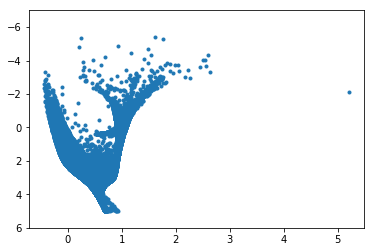

In [11]:
#Load mock catalogue
x = fits.getdata(fits_create)
print(len(x),x.dtype)
x = x.view(np.recarray)
plt.plot(x.gaia_bpft-x.gaia_rp,x.gaia_g,".")
plt.ylim(6,-7)


In [12]:
rgb = x[(x.gaia_g < -0.5) & (x.gaia_bpft - x.gaia_rp > 0.8)]
plt.plot(rgb.ubv_b-rgb.ubv_v,rgb.ubv_v,".")
plt.ylim(-0.4,-7)

AttributeError: recarray has no attribute ubv_b

In [ ]:
n,bins,patch =plt.hist(rgb.age, bins = 30, normed=True)
plt.xlabel("age")
plt.ylabel('sampling of red clump star population')

In [ ]:
new_bins= np.divide(bins[:-1] + bins [1:],2)
rgb_time = new_bins[::-1]
rgb_dist = n[::-1]
plt.plot(rgb_time,rgb_dist)
plt.xlabel("age")
plt.ylabel('sampling of RGB star population')
np.save('../output/selection/rgb_time.npy',rgb_time)
np.save('../output/selection/rgb.npy',rgb_dist)

In [ ]:
# This format now looks similar to the Chempy input, 
# except that the time axis does not exactly start and end at 0 and 13.5Gyr
# Might, but should not have an impact
rc = np.load('../input/chempy_selection/red_clump_new.npy')
rc_time = np.load('../input/chempy_selection/time_red_clump_new.npy')
plt.plot(rc_time,rc)
plt.xlabel("age")
plt.ylabel('sampling of red clump star population')